In [13]:
import numpy as np
import pandas as pd
from astropy import cosmology
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
import astropy.constants as const
def LoadSources(catalog_dir,
                catalog_file="ULIRG_selection.txt",
                redshift_max=1,#0.13,
                sinDec_min=-1.):
    '''
    Description
    -----------
    Function that reads out the catalog file of selected ULIRGs
    and loads in the information.
    
    
    Arguments
    ---------
    `catalog_dir`
    type        : str
    description : Directory of the catalog file.
    
    `catalog_file`
    type        : str
    description : Option to provide the name of the catalog file.
    
    `redshift_max`
    type        : float
    description : Option to specify the maximum redshift of the
                  sources that are loaded.
    
    `sinDec_min`
    type        : float
    description : Option to specfify the minimum declination of the
                  sources that are loaded.
                  
    Returns
    -------
    `ULIRGs`
    type        : dict
    description : Dictionary containing all the fields that are in the
                  catalog file. In particular it contains the fields
                  relevant for the ULIRG stacking analysis.
    '''
    
    print("\nLoading ULIRGs with z <= {} and sinDec >= {}".format(redshift_max,sinDec_min))

    # Open catalog file
    catalog = open(catalog_dir+catalog_file,"r")
    lines = catalog.readlines()

    # Lists of relevant ULIRG parameters
    # Easier to work with in first instance to load the ULIRG data
    name = []
    ra = []
    dec = []
    redshift = []
    f60 = []
    unc_f60 = []
    lum_IR = []
    catalog_info = []

    # Read out the catalog file
    # Assumes the structure of ULIRG_selection.txt
    start_readout = False
    for line in lines:
        # Skip first lines that do not contain data
        if start_readout == False and line[0][0] == "1":
            start_readout = True

        if start_readout == False:
            continue

        # Columns in the file are split with tabs
        columns = [column for column in line.split("\t") if column != ""]

        # Only load sources with a sinDec larger than `sinDec_min`
        # and with redshift smaller than `redshift_max`
        new_dec      = np.deg2rad( float(columns[3]) )
        new_redshift = float(columns[4])
        
        if np.sin( new_dec ) >= sinDec_min and new_redshift <= redshift_max:
            name.append(columns[1])
            ra.append( np.deg2rad( float(columns[2]) ) )
            dec.append( new_dec )
            redshift.append(float(columns[4]))
            f60.append(float(columns[5]))
            unc_f60.append(float(columns[6]))
            lum_IR.append(float(columns[7]))
            catalog_info.append(columns[8].split(" & "))

    catalog.close()

    # Convert the lists into arrays
    ra = np.array(ra) # [rad]
    dec = np.array(dec) # [rad]
    sinDec = np.sin(dec)
    redshift = np.array(redshift)
    f60 = np.array(f60) # [Jy]
    unc_f60 = np.array(unc_f60) # [Jy]
    lum_IR = np.array(lum_IR) # # [log10(L_sun)]

    # Calculate the luminosity distances
    # from the redshifts using astropy
    # Take the Planck 15 cosmology (H_0 = 67.7 km Mpc^-1 s^-1)
    # built in the astropy package
    distance = np.array(cosmology.Planck15.luminosity_distance(redshift)) # [Mpc]

    # Store all ULIRG parameters in one dictionary
    ULIRGs = {"name"       : name,
              "ra"         : ra,
              "dec"        : dec,
              "sinDec"     : sinDec,
              "redshift"   : redshift,
              "distance"   : distance,
              "f60"        : f60,
              "unc_f60"    : unc_f60,
              "log_lum_IR" : lum_IR,
              "catalog"    : catalog_info}

    # Return ULIRG dictionary
    print( "\nLOADED: {} ULIRGs".format(len(ra)) )
    return ULIRGs

In [14]:
ULIRGs = LoadSources('./')
data = pd.DataFrame(ULIRGs)


Loading ULIRGs with z <= 1 and sinDec >= -1.0

LOADED: 189 ULIRGs


In [15]:
def QIR(DL_compl):
    df = pd.DataFrame(data = ULIRGs)
    volume_limited = df[(df['distance'].values <= DL_compl)] 
    logLIR_complete_array = volume_limited['log_lum_IR'].to_numpy()
    LIR_array = pow(10,volume_limited['log_lum_IR']).values
    totalIR = (sum(LIR_array*u.solLum)).to(u.erg/u.yr)      
    Dmax = DL_compl*u.Mpc 
    Volume = (4/3)*pow(Dmax,3)*np.pi 
    return [(totalIR/Volume).value,totalIR.value]

In [16]:
data[data['redshift']<=0.13].sort_values(by = 'redshift')

,name,ra,dec,sinDec,redshift,distance,f60,unc_f60,log_lum_IR,catalog
133,ARP 220,4.079507,0.410207,0.398799,0.018126,81.328758,104.090,0.112,12.21,"[RBGS, FSC, PSCz + Spitzer]"
101,WKK 2031,3.469304,-0.962662,-0.820715,0.030761,139.318223,41.110,0.066,12.26,"[RBGS, PSCz + Spitzer]"
107,MRK 0273,3.598441,0.975410,0.827932,0.037780,171.986874,22.510,0.042,12.14,"[RBGS, FSC, PSCz + Spitzer]"
64,UGC 05101,2.512663,1.070815,0.877592,0.039367,179.417899,11.540,0.808,11.99,[PSCz + Spitzer\n]
99,MRK 0231,3.386974,0.992633,0.837468,0.042170,192.582800,30.800,0.042,12.51,"[RBGS, FSC, PSCz + Spitzer]"
...,...,...,...,...,...,...,...,...,...,...
29,2MASX J03274981+1616594,0.906829,0.284196,0.280386,0.129000,624.860673,1.381,0.083,12.06,"[FSC, PSCz + Spitzer]"
110,IRAS 13454-2956,3.614251,-0.527067,-0.503001,0.129000,624.860673,2.158,0.108,12.21,"[FSC, PSCz + Spitzer]"
10,GALEXASC J005040.35-270440.6,0.221097,-0.472600,-0.455203,0.129200,625.909198,1.134,0.136,12.00,"[FSC, PSCz + Spitzer]"
163,2MASX J20132950-4147354,5.294859,-0.729426,-0.666442,0.129583,627.917779,5.228,0.314,12.64,[PSCz + Spitzer]


In [17]:
diff = [QIR(d)[0] for d in data.sort_values(by = 'distance')['distance'].values]


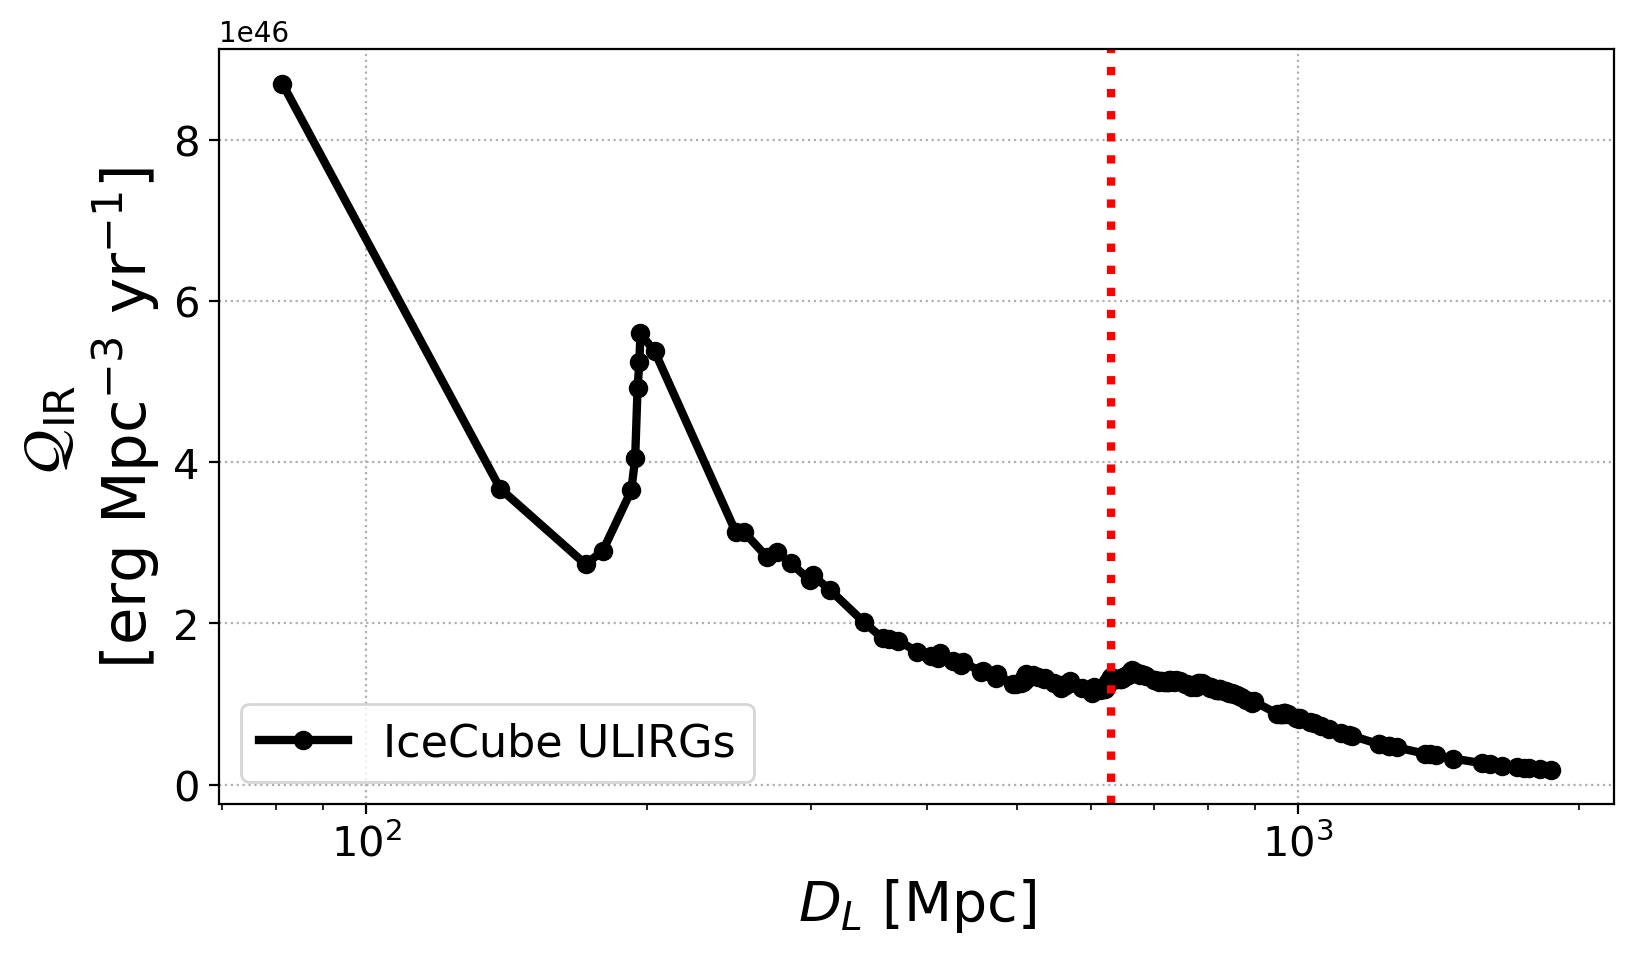

In [21]:
plt.figure(figsize=(9,5),dpi=200)

plt.plot(data.sort_values(by = 'distance')['distance'].values,diff,c = 'k', marker = 'o',ls = '-',label = 'IceCube ULIRGs',linewidth =3)
plt.axvline(x = 630,c='red',ls='dotted',lw=3)
plt.ylabel('$\\mathcal{Q}_{\\mathrm{IR}}$ \n [erg Mpc$^{-3}$ yr$^{-1}$]', fontsize = 22)
plt.legend(fontsize = 16)
plt.xlabel('$D_L$ [Mpc]',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(ls ='dotted')
plt.xscale('log')

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

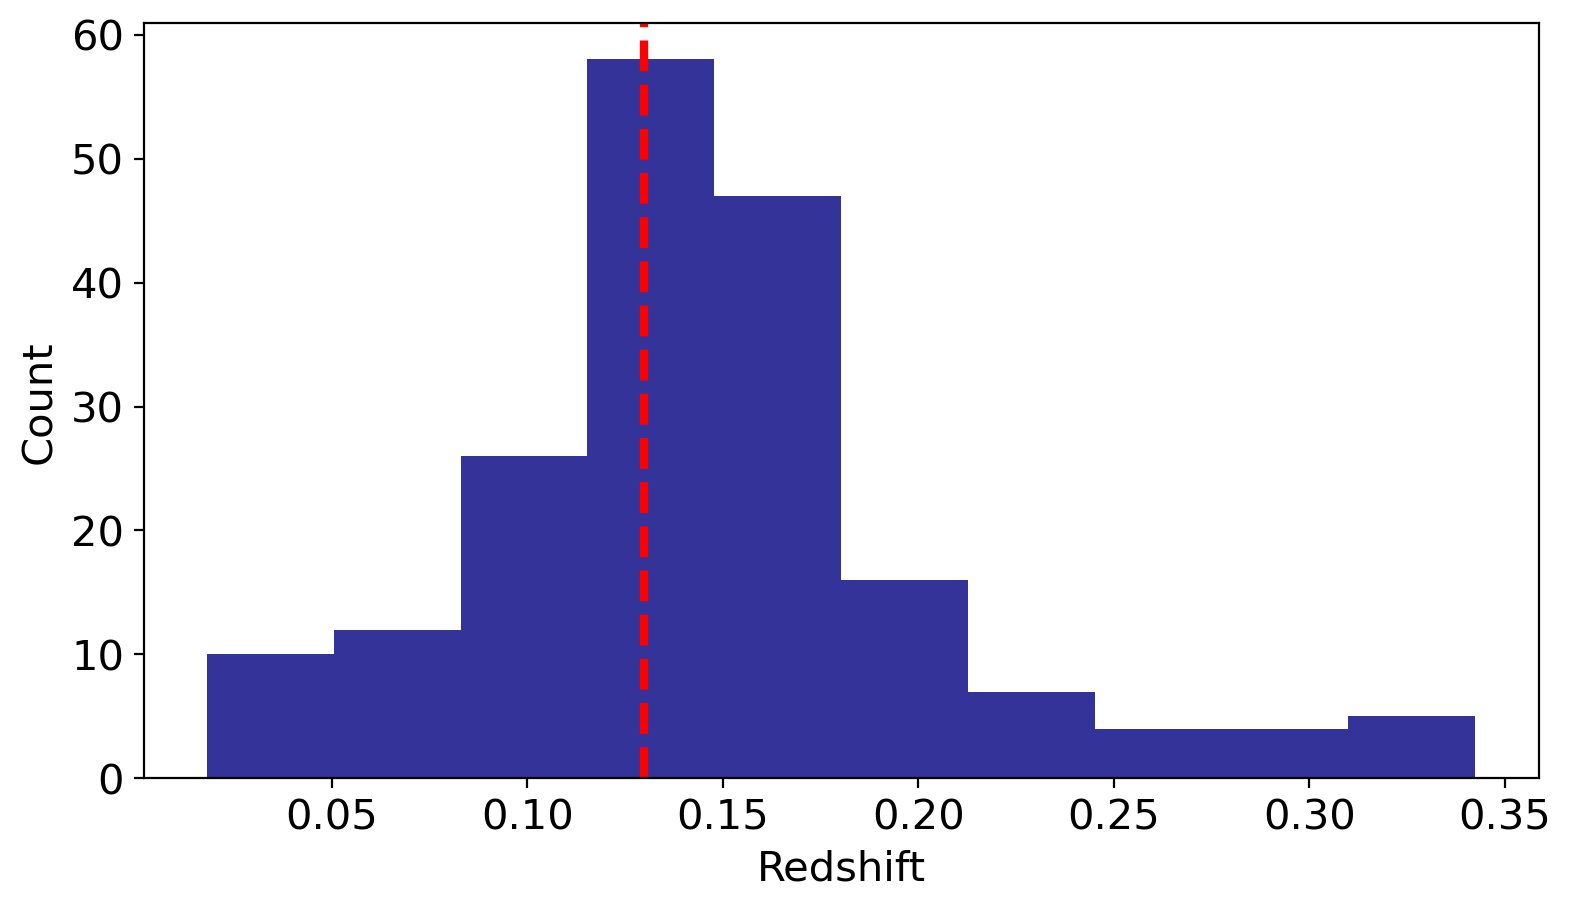

In [8]:
plt.figure(figsize=(9,5),dpi=200)

plt.hist(data['redshift'],color='navy',alpha = 0.8)
plt.axvline(x=0.13,color = 'red',ls ='dashed',lw = 3)
plt.xlabel('Redshift',fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [8]:
def pl(E,E0,phi0,gamma):
    return phi0*pow(E/E0,-gamma+2)
pl = np.vectorize(pl)

In [9]:
def nu_flux(E,eta_tot,xiz,alpha,QIR,fpp ,Emin, Emax):
    if alpha == 2:
        Rp = np.log(Emax/Emin)
    else:
        Rp = ((pow(Emin,-alpha+2)-pow(Emax,-alpha+2))/(alpha-2))*pow(E,alpha-2)    
    diff = (QIR*eta_tot)/Rp
    
    print(Rp)
    tH = (pow(cosmo.H(0),-1)).to((u.Mpc*u.s)/u.Mpc) #inverse of Hubble parameter in seconds
    ctH = (const.c).to(u.cm/u.s)*tH # unit: cm
    Generation_rate_nunits = (diff*(u.erg/(pow(u.Mpc,3)*u.yr))).to(u.GeV/(pow(u.cm,3)*u.s)) #unit: GeV/(cm3 s)
    factor = 0.5
    nu_flux = ((1/3)*((ctH*xiz)/(4*np.pi))*factor*fpp*Generation_rate_nunits).value*1e-3# unit: TeV/(cm2 s sr)
    return nu_flux



In [10]:
QIR= QIR(630)[0]
Erange_g2 = np.logspace(np.log10(10*1e3),np.log10(1e4*1e3),12) 
Erange_g25 = np.logspace(np.log10(1*1e3),np.log10(5*1e5),12) 
Erange_g3 = np.logspace(np.log10(10**2.6),np.log10(10**4.8),12)
#20*1e3,20*1e6
#note the Emin and Emax
ul_gamma2 = np.ones(len(Erange_g2))*4e-12
ulirg_predic_g2 = [nu_flux(E,eta_tot = 0.0018,xiz = 3.4,alpha= 2., QIR = QIR, 
                        fpp = 1.,Emin=1e3, Emax=60*1e6) for E in Erange_g2]

ulirg_predic_g25 = [nu_flux(E,eta_tot = 0.0018,xiz = 3.4,alpha= 2.5, QIR = QIR, 
                        fpp = 1.,Emin=1e3, Emax=60*1e6) for E in Erange_g25]

ulirg_predic_g3 = [nu_flux(E,eta_tot = 0.0018,xiz = 3.4,alpha= 3, QIR = QIR, 
                        fpp = 1.,Emin=1e3, Emax=60*1e6) for E in Erange_g3]

11.002099841204238
11.002099841204238
11.002099841204238
11.002099841204238
11.002099841204238
11.002099841204238
11.002099841204238
11.002099841204238
11.002099841204238
11.002099841204238
11.002099841204238
11.002099841204238
1.9918350341907225
2.642006134106618
3.504404879339333
4.6483062245008915
6.165597726483914
8.17816070818471
10.847660768007579
14.38853408933438
19.085212717060596
25.31497247697051
33.578238870605254
44.538785364160724
0.39810053543398816
0.6309468285244524
0.9999833333333334
1.5848667775745733
2.5118445667357214
3.9810053543398816
6.309468285244518
9.999833333333335
15.848667775745733
25.118445667357243
39.81005354339877
63.094682852445175


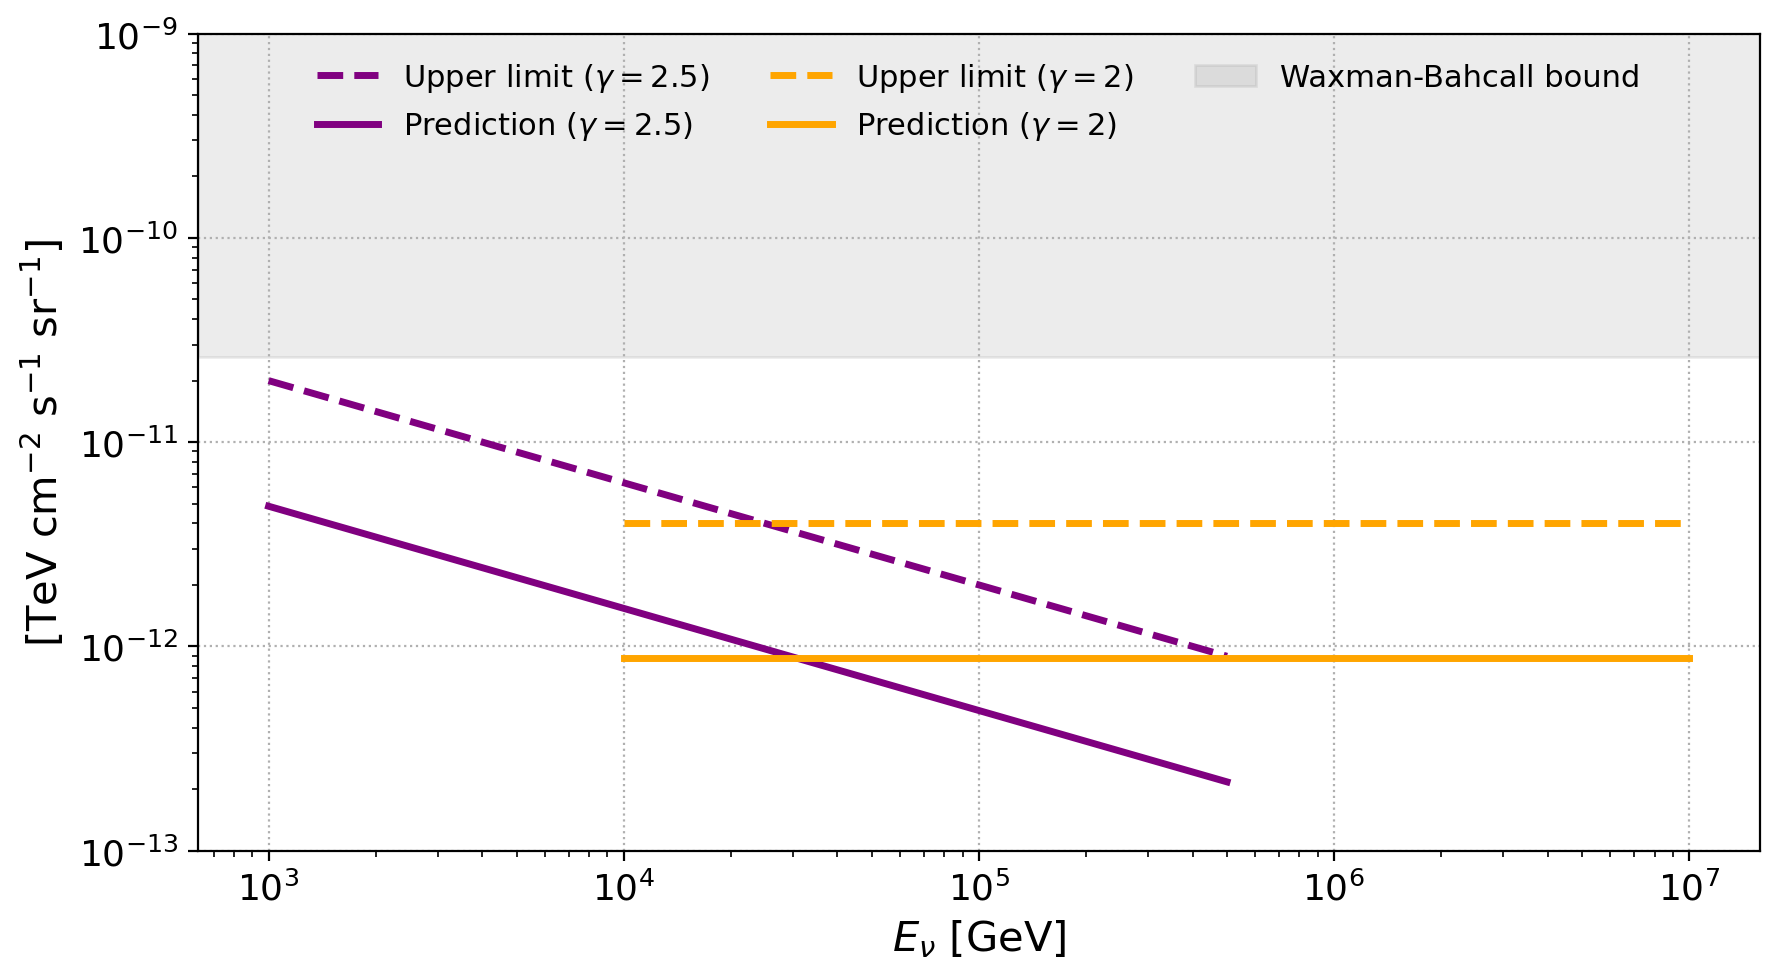

In [25]:
plt.figure(figsize=(9, 5), dpi=200)

# Plot gamma = 2.5
plt.plot(Erange_g25, pl(Erange_g25, 1e3, 2e-11, 2.5), 
         linestyle='dashed', color='purple', lw=2.5, 
         label='Upper limit ($\\gamma = 2.5$)')
plt.plot(Erange_g25, ulirg_predic_g25, 
         color='purple', lw=2.5, 
         label='Prediction ($\\gamma=2.5$)')

# Plot gamma = 2
plt.plot(Erange_g2, ul_gamma2, 
         linestyle='dashed', color='orange', lw=2.5, 
         label='Upper limit ($\\gamma = 2$)')
plt.plot(Erange_g2, ulirg_predic_g2, 
         color='orange', lw=2.5, 
         label='Prediction ($\\gamma=2$)')

# Optional: Commented out gamma = 3 for less clutter
# plt.plot(Erange_g3, pl(Erange_g3, 10**2.6, 1e-10, 3),
#          linestyle='--', color='pink', lw=2, 
#          label='Upper limit ($\\gamma = 3$)')
# plt.plot(Erange_g3, ulirg_predic_g3,
#          color='pink', lw=2,
#          label='Prediction ($\\gamma=3$)')

# Waxman-Bahcall bound
plt.axhspan(2 * 1e-11 * 1.3, 5e-9, 
            alpha=0.15, color='grey', label='Waxman-Bahcall bound')

# Grid and axes
plt.grid(ls='dotted')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-13, 1e-9)
plt.xlabel('$E_\\nu$ [GeV]', fontsize=15)
plt.ylabel('[TeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]', fontsize=15)

# Ticks
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Legend
plt.legend(fontsize=11, loc='upper center', ncol=3, frameon=False)

plt.tight_layout()
plt.show()


In [24]:
print('ULIRG flux: ', nu_flux(-1,eta_tot = 0.0018,xiz = 3.4,alpha= 2., QIR = QIR, 
                        fpp = 1.,Emin=20*1e3, Emax=20*1e6)*1e3,' in GeV cm-2 s-1 sr-1')

6.907755278982137
ULIRG flux:  1.3998133206791646e-09  in GeV cm-2 s-1 sr-1
